In [50]:
id = 6

In [51]:
pID = 'sub-' + "%01d" % (id)

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
# from sklearn.ensemble import RandomForestClassifier as RFC
# from sklearn.ensemble import AdaBoostClassifier as ABC

from sklearn.model_selection import cross_val_score, KFold

import pickle, json, os
import scipy.io

from bci_funcs import bandpass_filter_fft, calculate_velocity, gaze_remove_invalid_samples

path = 'P:\\Lukas_Gehrke\\NAH\\data\\5_single-subject-EEG-analysis'
# path = '/Volumes/Lukas_Gehrke/NAH/data/5_single-subject-EEG-analysis'
# path = '/Users/lukasgehrke/data/NAH/data/5_single-subject-EEG-analysis'

# Explore Behavior

In [52]:
behavior = pd.read_csv(path+os.sep+pID+os.sep+'behavior_s'+str(id)+'.csv', sep=';')

In [53]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for AccuracyCm
Q1_AccuracyCm = behavior['AccuracyCm'].quantile(0.25)
Q3_AccuracyCm = behavior['AccuracyCm'].quantile(0.75)

# Calculate IQR for AccuracyCm
IQR_AccuracyCm = Q3_AccuracyCm - Q1_AccuracyCm

# Define the lower and upper bounds for outliers in AccuracyCm
lower_bound_AccuracyCm = Q1_AccuracyCm - 1.5 * IQR_AccuracyCm
upper_bound_AccuracyCm = Q3_AccuracyCm + 1.5 * IQR_AccuracyCm

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for fix_delay
Q1_fix_delay = behavior['fix_delay'].quantile(0.25)
Q3_fix_delay = behavior['fix_delay'].quantile(0.75)

# Calculate IQR for fix_delay
IQR_fix_delay = Q3_fix_delay - Q1_fix_delay

# Define the lower and upper bounds for outliers in fix_delay
lower_bound_fix_delay = Q1_fix_delay - 1.5 * IQR_fix_delay
upper_bound_fix_delay = Q3_fix_delay + 1.5 * IQR_fix_delay

# Filter out the outliers
behavior_filt = behavior[
    (behavior['AccuracyCm'] >= lower_bound_AccuracyCm) & (behavior['AccuracyCm'] <= upper_bound_AccuracyCm) &
    (behavior['fix_delay'] >= lower_bound_fix_delay) & (behavior['fix_delay'] <= upper_bound_fix_delay)
]

# print both behavior and behavior_filt shape with some text
print('Behavior shape:', behavior.shape)
print('Behavior_filt shape:', behavior_filt.shape)

behavior = behavior_filt

Behavior shape: (23, 13)
Behavior_filt shape: (20, 13)


C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


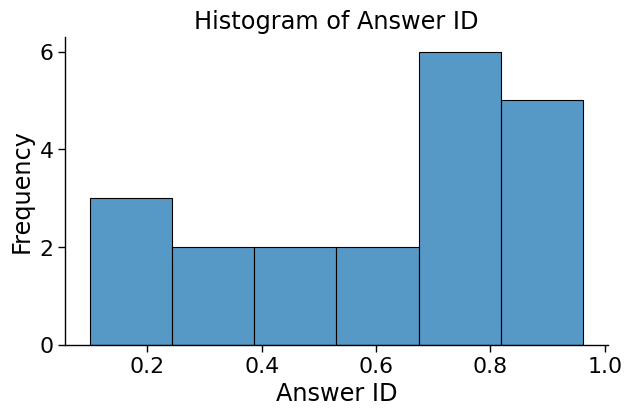

In [54]:
with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(7,4))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    sns.histplot(behavior_filt['answerID']) #, binwidth=1, binrange=(0.5, 5.5), kde=False)
    plt.xlabel('Answer ID')
    plt.ylabel('Frequency')
    plt.title('Histogram of Answer ID')
    plt.show()

C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\P

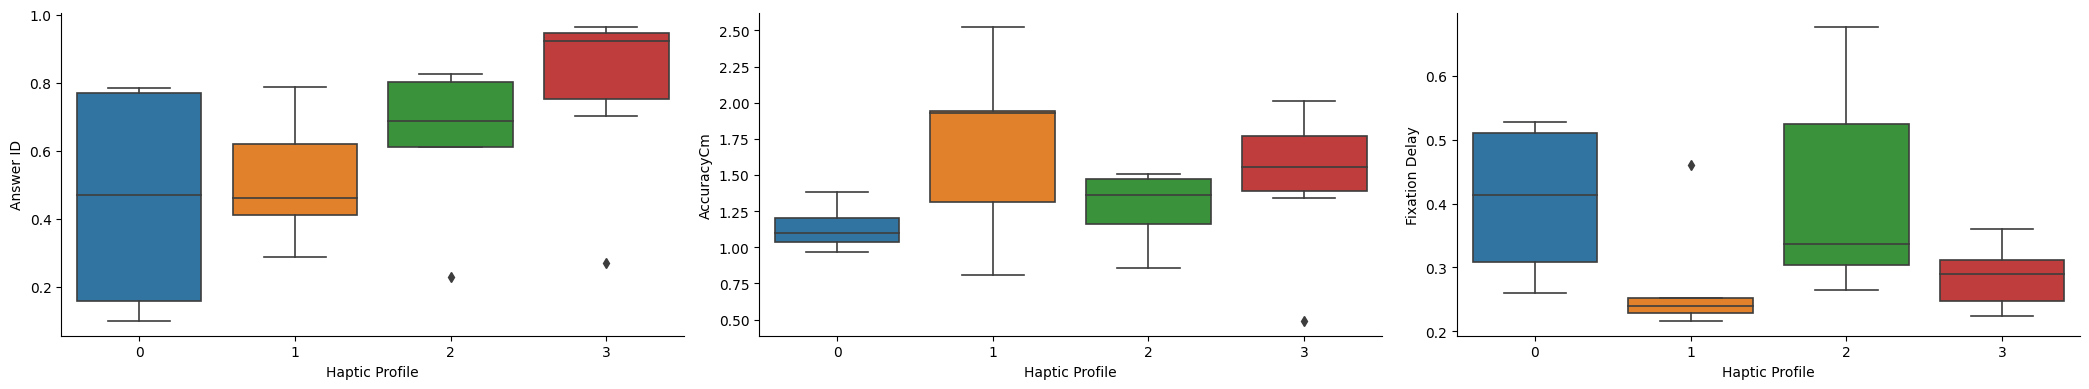

In [55]:
# Define the order for the hapticProfile categories
haptic_order = sorted(behavior['hapticProfile'].unique())

# Convert the hapticProfile column to a categorical type with the specified order
behavior['hapticProfile'] = pd.Categorical(behavior['hapticProfile'], categories=haptic_order, ordered=True)

fig, axs = plt.subplots(1, 3, figsize=(21, 4))
fig.patch.set_alpha(1)

with sns.plotting_context('paper', font_scale=1.8):
    sns.despine()
    sns.boxplot(x='hapticProfile', y='answerID', data=behavior, ax=axs[0])
    axs[0].set_xlabel('Haptic Profile')
    axs[0].set_ylabel('Answer ID')

with sns.plotting_context('paper', font_scale=1.8):
    sns.despine()
    sns.boxplot(x='hapticProfile', y='AccuracyCm', data=behavior, ax=axs[1])
    axs[1].set_xlabel('Haptic Profile')
    axs[1].set_ylabel('AccuracyCm')

with sns.plotting_context('paper', font_scale=1.8):
    sns.despine()
    sns.boxplot(x='hapticProfile', y='fix_delay', data=behavior, ax=axs[2])
    axs[2].set_xlabel('Haptic Profile')
    axs[2].set_ylabel('Fixation Delay')

plt.tight_layout()
plt.show()


# Neuroadaptive Haptics BCI Training

In [56]:
# load data
erp = scipy.io.loadmat(path+os.sep+pID+os.sep+'erp.mat')['erp']
gaze = scipy.io.loadmat(path+os.sep+pID+os.sep+'gaze.mat')['gaze']
hand_motion = scipy.io.loadmat(path+os.sep+pID+os.sep+'hand_motion.mat')['hand_motion']

### Signal Processing

In [57]:
# ERP
# Apply the bandpass filter to the ERP data
erp = bandpass_filter_fft(erp, .1, 15, 250)

# Gaze
gaze_vel = np.zeros((gaze.shape[1], gaze.shape[2]))
# Calculate the velocity for each trial
for i in range(gaze.shape[2]):
    gaze_vel[:, i] = calculate_velocity(gaze[:, :, i])
# remove invalid samples
for i in range(gaze.shape[2]):
    gaze_vel[:, i] = gaze_remove_invalid_samples(gaze_vel[:,i], gaze[-1,:,i])

# Hand motion
hand_vel = np.zeros((hand_motion.shape[1], hand_motion.shape[2]))
# Calculate the velocity for each trial
for i in range(hand_motion.shape[2]):
    hand_vel[:, i] = calculate_velocity(hand_motion[:, :, i])
# add a singleton dim in 1st place for hand_vel
hand_vel = np.expand_dims(hand_vel, axis=0)
# Apply the bandpass filter to the ERP data
hand_vel = bandpass_filter_fft(hand_vel, .1, 15, 250)
# drop singleton dim
hand_vel = np.squeeze(hand_vel, axis=0)

## Select Data and Assign to Classes

In [58]:
# Simplest approach: select indeces in behavior where answerID is > mean
# this will work with values obtained from a continuous slider in VR where a clear split at the median is possible

high = behavior[behavior['answerID'] > behavior['answerID'].median()].index # ! TODO change to mean
low = behavior[behavior['answerID'] < behavior['answerID'].median()].index # ! TODO change to mean

# temporary solution for testing
# high = behavior[behavior['answerID'] >= 3].index
# low = behavior[behavior['answerID'] < 3].index

## Plots

### EEG

C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in 

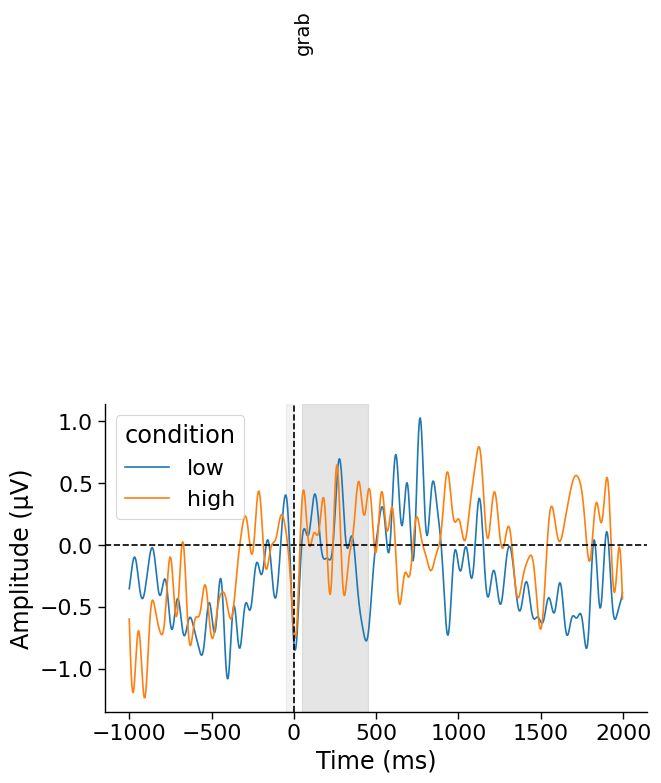

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# erp low
erp_low = erp[:,:,low]
# erp high
erp_high = erp[:,:,high]

plot_erp_low = np.mean(erp_low[2,:,:], axis=1)
plot_erp_high = np.mean(erp_high[2,:,:], axis=1)

erp_baseline_tw = np.arange(225, 250)

# ! fix for final correct baseline correction -> however this is just for plot
plot_erp_low = plot_erp_low - np.mean(plot_erp_low[erp_baseline_tw])
plot_erp_high = plot_erp_high - np.mean(plot_erp_high[erp_baseline_tw])

# merge both conditions
df = pd.DataFrame()
# voltage vector
df['low'] = plot_erp_low
df['high'] = plot_erp_high

# melt
df = pd.melt(df, value_vars=['low', 'high'], var_name='condition', value_name='voltage')

# time vector
df['time'] = np.tile(np.arange(0, len(plot_erp_low)),2)# - 50
df['time'] = (df['time'] * 1/250 * 1000) - 1000

with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(7,4))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    # sns.lineplot(x='time', y='voltage', hue='condition', style='control', data=df, ax=ax, errorbar='ci')
    sns.lineplot(x='time', y='voltage', hue='condition', data=df, ax=ax, errorbar='ci')
    # sns.lineplot(x='time', y='voltage', hue='control', data=df, ax=ax, errorbar='ci')

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude (μV)')

    # xline at 0 with text label 's'
    ax.axvline(0, color='black', linestyle='--')
    ax.text(.1, 4, 'grab', fontsize=14, rotation=90)

    # yline at 0
    ax.axhline(0, color='black', linestyle='--')

    # mark area of feature extraction add a grey background to the y axis range 100 - 300ms
    ax.axvspan(50, 450, color='grey', alpha=0.2, label='features')
    ax.axvspan(-50, 0, color='grey', alpha=0.1, label='baseline')

    # move legend to the right
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # save as eps
    # plt.tight_layout()
    # plt.savefig('/Users/lukasgehrke/Desktop/erp_diff.pdf', format='pdf', dpi=300)

### Motion

C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in 

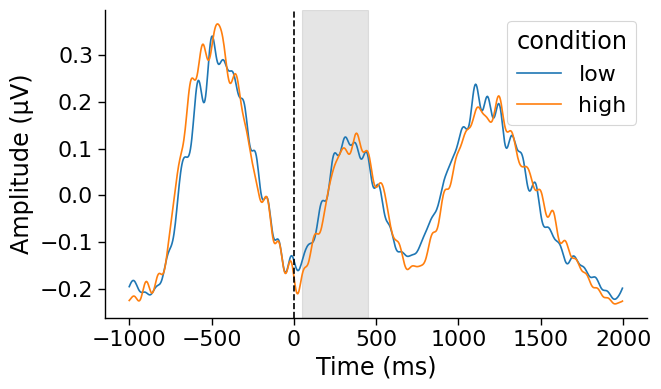

In [60]:
# erp low
erp_low = hand_vel[:,low].mean(axis=1)
# erp high
erp_high = hand_vel[:,high].mean(axis=1)

# merge both conditions
df = pd.DataFrame()
# voltage vector
df['low'] = erp_low
df['high'] = erp_high

# melt
df = pd.melt(df, value_vars=['low', 'high'], var_name='condition', value_name='voltage')

# time vector
df['time'] = np.tile(np.arange(0, len(erp_low)),2)# - 50
df['time'] = (df['time'] * 1/250 * 1000) - 1000

with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(7,4))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    # sns.lineplot(x='time', y='voltage', hue='condition', style='control', data=df, ax=ax, errorbar='ci')
    sns.lineplot(x='time', y='voltage', hue='condition', data=df, ax=ax, errorbar='ci')
    # sns.lineplot(x='time', y='voltage', hue='control', data=df, ax=ax, errorbar='ci')

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude (μV)')

    # xline at 0 with text label 's'
    ax.axvline(0, color='black', linestyle='--')
    # ax.text(-5, .1, 'grab', fontsize=14, rotation=90)

    # yline at 0
    # ax.axhline(0, color='black', linestyle='--')

    # ! mark area of feature extraction add a grey background to the y axis range 100 - 300ms
    ax.axvspan(50, 450, color='grey', alpha=0.2, label='features')
    # ax.axvspan(0, 50, color='grey', alpha=0.1, label='baseline')

    # move legend to the right
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # save as eps
    # plt.tight_layout()
    # plt.savefig('/Users/lukasgehrke/Desktop/erp_diff.pdf', format='pdf', dpi=300)

### EYE Tracking

### Fixations

C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will

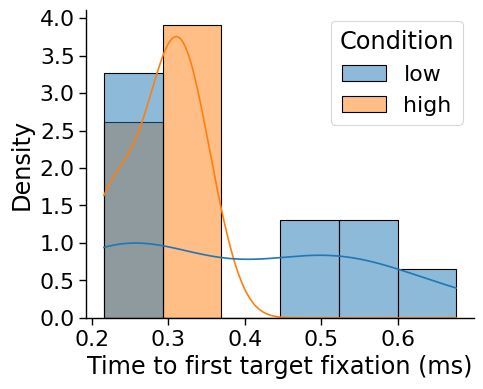

In [61]:
fixation_low = np.array(behavior.loc[low, 'fix_delay']).reshape(1, -1)
fixation_high = np.array(behavior.loc[high, 'fix_delay']).reshape(1, -1)

data = np.concatenate((fixation_low, fixation_high), axis = 1).T
low_class = np.zeros((fixation_low.shape[1], 1))
high_class = np.ones((fixation_high.shape[1], 1))
classes = np.concatenate((low_class, high_class)).ravel()

data_to_plot = pd.DataFrame(data)
data_to_plot['Condition'] = classes
# rename zeros in Condition to low and ones to high
data_to_plot['Condition'] = data_to_plot['Condition'].replace({0: 'low', 1: 'high'})
data_to_plot = data_to_plot.melt(id_vars = 'Condition', value_name = 'amplitude')

import seaborn as sns
import matplotlib.pyplot as plt

with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(5,4))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    sns.histplot(x="amplitude", hue="Condition", data=data_to_plot, kde=True, fill=True, stat="density", legend=True)

    # xlabel
    plt.xlabel('Time to first target fixation (ms)')


# Compute Features

In [62]:
sample_event = 250
data_selection = 108 # 8 windows with 12 samples each
samples_of_int = np.arange(sample_event, sample_event+data_selection)

### ERPs

In [63]:
erp_selected = erp[:,samples_of_int,:]
erp_selected = erp_selected.reshape(erp_selected.shape[0], 9, 12, erp_selected.shape[2])
erp_selected = np.mean(erp_selected, axis=2)
baseline = erp_selected[:,0,:]
erp_corrected = erp_selected - baseline[:,np.newaxis,:]

erp_low = erp_corrected[:,:,low]
erp_high = erp_corrected[:,:,high]

C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values t

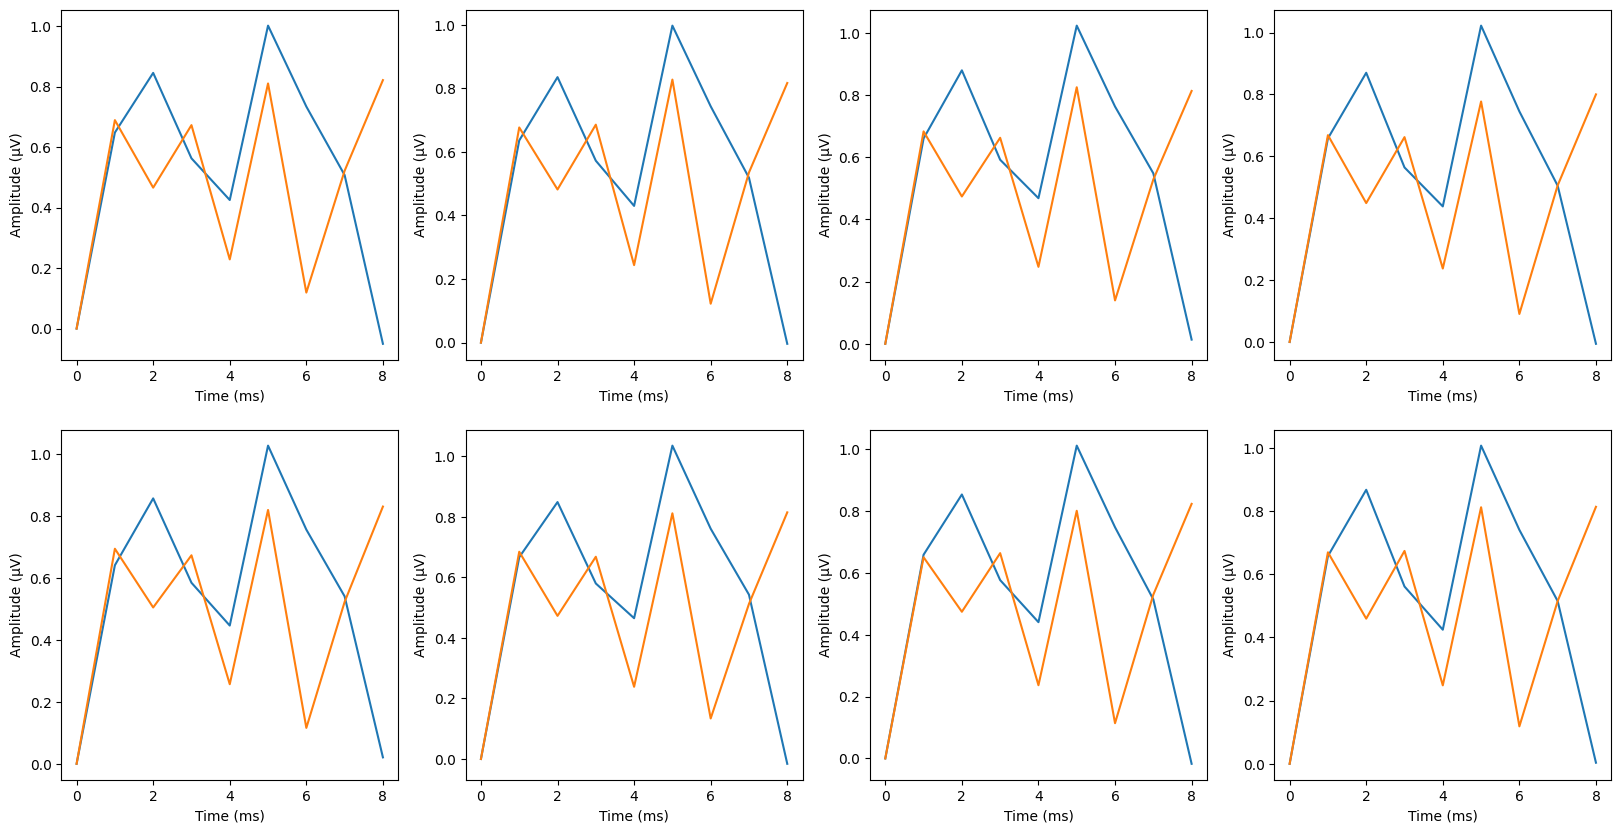

In [64]:
erp_low_plot = np.mean(erp_low, axis=2)
erp_high_plot = np.mean(erp_high, axis=2)

# plot them
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.patch.set_alpha(1)

for i, ax in enumerate(axs.flat):
    sns.lineplot(data=erp_low_plot[i], ax=ax, errorbar='sd')
    sns.lineplot(data=erp_high_plot[i], ax=ax, errorbar='sd')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude (μV)')

### Channel Selection

In [65]:
# Compute the mean ERP for each class
mean_erp_low = np.mean(erp_low, axis=2)
mean_erp_high = np.mean(erp_high, axis=2)

# Subtract the mean ERP of the high class from the mean ERP of the low class
erp_diff = mean_erp_low - mean_erp_high

# Compute the mean over the 8 windows for each channel
erp_diff_mean = np.mean(erp_diff, axis=1)

# Sort the channels by the absolute differences
sorted_channels = np.argsort(np.abs(erp_diff_mean))[::-1]

# Print the sorted channels
print("Sorted channels by differences:", sorted_channels)

# select the top 10 channels
top_channels = sorted_channels[:10] # needs to be saved for real-time application

# save the top channels
with open(path+os.sep+pID+os.sep+'top_channels.json', 'w') as f:
    json.dump(top_channels.tolist(), f)

Sorted channels by differences: [53 37 47 34 55 44 56 39 62 50 51 46 36 60 35 45 58 42 57 52 33 41 32 49
 54 38 63 59 40 43 48 61  9 12 16 28 30 23 20 29 18  3 15 14 27 19  2 24
  5 13 11 17 21  6  7  4 22  8 25 10  0 31  1 26]


### Hand motion

In [66]:
hand_vel_selected = hand_vel[samples_of_int,:]
hand_vel_selected = hand_vel_selected.reshape(9, 12, hand_vel_selected.shape[1])
hand_vel_selected = np.mean(hand_vel_selected, axis=1)
# baseline = hand_vel_selected[:,0,:]
# erp_corrected = hand_vel_selected - baseline[:,np.newaxis,:]

hand_vel_low = hand_vel_selected[:,low]
hand_vel_high = hand_vel_selected[:,high]

C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values t

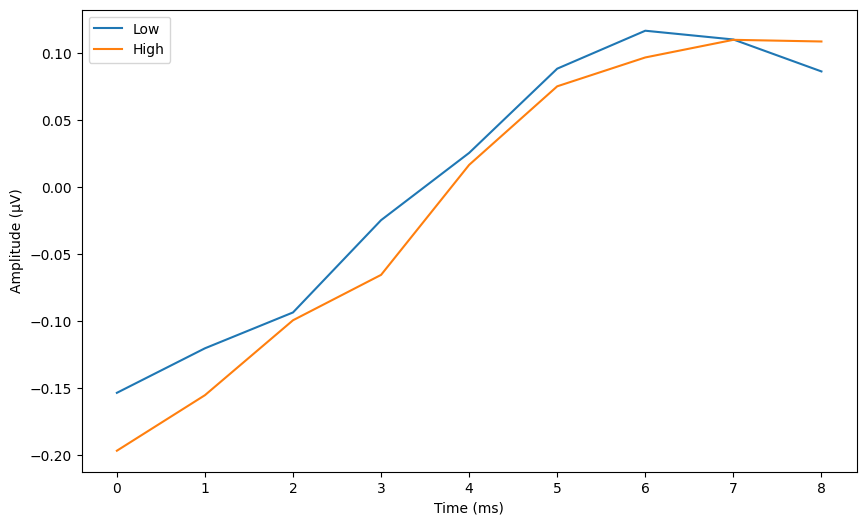

In [67]:
hand_vel_low_plot = np.mean(hand_vel_low, axis=1)
hand_vel_high_plot = np.mean(hand_vel_high, axis=1)

# plot them
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_alpha(1)

sns.lineplot(data=hand_vel_low_plot, ax=ax, errorbar='sd', label='Low')
sns.lineplot(data=hand_vel_high_plot, ax=ax, errorbar='sd', label='High')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (μV)')
ax.legend()
plt.show()

## Eye Tracking

In [68]:
# EYE - gaze velocity? fixation frequency per second?


# EYE - time to first target fixation
fixation_low = np.array(behavior.loc[low, 'fix_delay']).reshape(1, -1)
fixation_high = np.array(behavior.loc[high, 'fix_delay']).reshape(1, -1)

# Fit Model and Cross-validate

### Feature Vector

In [69]:
# drop baseline dim
erp_low = erp_low[top_channels,1:9,:]
erp_high = erp_high[top_channels,1:9,:]
hand_vel_low = hand_vel_low[1:9,:]
hand_vel_high = hand_vel_high[1:9,:]
erp_low_flattened = erp_low.reshape(-1, erp_low.shape[-1])
erp_high_flattened = erp_high.reshape(-1, erp_high.shape[-1])

# concat all low features
# features_low = np.concatenate((erp_low_flattened, hand_vel_low), axis=0)
features_low = np.concatenate((erp_low_flattened, hand_vel_low, fixation_low), axis=0)
# features_low = hand_vel_low
# concat all high features
# features_high = np.concatenate((erp_high_flattened, hand_vel_high), axis=0)
features_high = np.concatenate((erp_high_flattened, hand_vel_high, fixation_high), axis=0)
# features_high = hand_vel_high

### Train-Test Split

In [70]:
data = np.concatenate((features_low, features_high), axis = 1).T
low_class = np.zeros((features_low.shape[1], 1))
high_class = np.ones((features_high.shape[1], 1))
classes = np.concatenate((low_class, high_class)).ravel()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(data)
pickle.dump(scaler, open(path+os.sep+pID+os.sep+'scaler.sav', 'wb'))

# generate a train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, classes, test_size=0.2, random_state=42)

### Model fitting

In [71]:
clf = LDA(solver='eigen', shrinkage='auto')

# Perform cross-validation on the training data
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")

# Train the LDA model on the entire training set
clf.fit(X_train, y_train)

# Apply the classifier to the validation set
val_scores = clf.transform(X_test)
# print(f"Validation scores: {val_scores}")

# Set boundaries based on cross-validation scores
boundary_scores = clf.transform(X_test)

boundary_low = np.percentile(boundary_scores, 5)
# boundary_low = np.min(boundary_scores)
boundary_high = np.percentile(boundary_scores, 95)
# boundary_high = np.max(boundary_scores)
print(f"Boundaries: {boundary_low}, {boundary_high}")

# save low and high boundary
with open(path+os.sep+pID+os.sep+'boundaries.json', 'w') as f:
    json.dump([boundary_low, boundary_high], f)

# min max scaling
boundary_scores = (boundary_scores - boundary_scores.min()) / (boundary_scores.max() - boundary_scores.min())
print(f"Boundary scores: {boundary_scores}")

# Check how the boundaries work with the validation set
predictions = (boundary_scores > boundary_low) & (boundary_scores < boundary_high)
print(f"Predictions within boundaries: {predictions}")

clf.fit(data, classes)

kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 
cv_results = cross_val_score(clf, data, classes, cv=kfolds)
acc = cv_results.mean()
acc_std = cv_results.std()
print("Full Model with all training data LDA accuracy: " + str(cv_results.mean()) + " +/- " + str(cv_results.std()))

# save model
filename = path+os.sep+pID+os.sep+'model.sav'
pickle.dump(clf, open(filename, 'wb'))

# save BCI params
target_class = 1
mean_fix_delay = np.mean(behavior['fix_delay'])

# 'f1', 'threshold',
bci_params = dict(((k, eval(k)) for k in ('target_class', 'acc', 'acc_std', 'mean_fix_delay')))
with open(path+os.sep+pID+os.sep+'bci_params.json', 'w') as f:
    json.dump(bci_params, f)
print(bci_params)

Cross-validation scores: [0.25       1.         0.66666667 0.66666667 0.33333333]
Mean cross-validation score: 0.5833333333333333
Boundaries: -1.3853181388545717, 2.4358482079243102
Boundary scores: [[0.        ]
 [0.22305323]
 [1.        ]
 [0.1958812 ]]
Predictions within boundaries: [[ True]
 [ True]
 [ True]
 [ True]]
Full Model with all training data LDA accuracy: 0.5 +/- 0.31622776601683794
{'target_class': 1, 'acc': 0.5, 'acc_std': 0.31622776601683794, 'mean_fix_delay': 0.3416}


C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lukas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


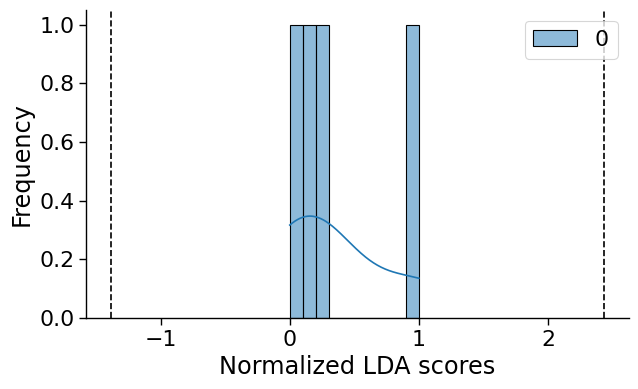

In [72]:
with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(7,4))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    sns.histplot(boundary_scores, binwidth=0.1, kde=True, ax=ax)
    # xline boundaries
    ax.axvline(boundary_low, color='black', linestyle='--')
    ax.axvline(boundary_high, color='black', linestyle='--')
    plt.xlabel('Normalized LDA scores')
    plt.ylabel('Frequency')
    # plt.title('Histogram of decision function scores')
    plt.show()


In [73]:
# print("Predicted classes: ", pred_classes)
# print("Actual classes:    ", y_test)

# # confusion matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, pred_classes)
# print("Confusion matrix: ")
# print(cm)

# # ROC curve
# from sklearn.metrics import roc_curve, roc_auc_score

# fpr, tpr, thresholds = roc_curve(y_test, predictions_prob[:,1])
# roc_auc = roc_auc_score(y_test, predictions_prob[:,1])


# # plot ROC curve
# fig, ax = plt.subplots(figsize=(6, 6))
# fig.patch.set_alpha(1)

# plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()


In [74]:
# # plot histogram of scores
# data_to_plot = pd.DataFrame(scores)
# data_to_plot['Condition'] = X_test
# # rename zeros in Condition to low and ones to high
# data_to_plot['Condition'] = data_to_plot['Condition'].replace({0: 'low', 1: 'high'})
# data_to_plot = data_to_plot.melt(id_vars = 'Condition', value_name = 'score')

# import seaborn as sns

# with sns.plotting_context('paper', font_scale = 1.8):

#     ### Create new plot
#     fig, ax = plt.subplots(1, 1, figsize=(5,4))
#     fig.patch.set_alpha(1)

#     sns.despine() #bottom=True, left=True

#     sns.histplot(x="score", hue="Condition", data=data_to_plot, kde=True, fill=True, stat="density", legend=True)

#     # add xlines for boundaries variable
#     for boundary in boundaries:
#         ax.axvline(boundary, color='black', linestyle='--')

#     # xlabel
#     plt.xlabel('LDA score')

### ROC interpolated

In [75]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# def plot_roc_curve(fpr, tpr):
#     plt.plot(fpr, tpr, color='orange', label='ROC')
#     plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) Curve')
#     plt.legend()
#     plt.show()

# def interp_roc_curve(true, score, by ='fp', byval = np.linspace(0,1,101)):
#     fp, tp, th =  roc_curve(true, score)
#     data = {'fp': fp, 'tp': tp, 'th': th}
#     interpData = {}
#     for k,v in data.items():
#         if k==by:
#             interpData[k] = byval
#         else:
#             interpData[k] = np.interp(byval, data[by], data[k])
#     roc = pd.DataFrame.from_dict(interpData)
#     return(roc)

# roc = interp_roc_curve(classes, predictions_prob[:,1])

# false_positive_rate, recall, thresholds = roc_curve(classes, predictions_prob[:,1])

# np.savetxt(path+os.sep+pID+os.sep+'fpr.csv', roc.fp, delimiter=',')
# np.savetxt(path+os.sep+pID+os.sep+'recall.csv', roc.tp, delimiter=',')

# roc_auc = auc(false_positive_rate, recall)
# plot_roc_curve(false_positive_rate, recall)

# optimal_idx = np.argmax(recall - false_positive_rate)
# optimal_threshold = thresholds[optimal_idx]
# print("Threshold value is:", optimal_threshold)

# from sklearn.metrics import f1_score
# f1 = f1_score(classes, pred_classes)
# print("F1 Score: "+ str(f1_score(classes, pred_classes)))

# # threshold = cv_results.mean()
# threshold = np.min(thresholds[false_positive_rate<.2])
# print("Threshold used is:", threshold)